### <font color = 'green'> Preparación de entorno

Descarga de librerías

In [1]:
%%capture
!pip install 'cartopy==0.18.0'
!pip install shapely --no-binary shapely --force
!pip install geopandas
!pip install 'xarray==0.19.0'
# !pip install rioxarray

In [2]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

##### CONFIGURACIÓN DE ENTORNO #####
from google.colab import drive     # Conectar Google drive
drive.mount('/content/drive/')

import xarray as xr, pandas as pd, numpy as np, matplotlib.pyplot as plt
import os

path = '/content/drive/MyDrive/Trabajos_UNALM/I.O.A./P3_IOA/'  # Directorio de trabajo (cambiar aquí)
path_data = '/content/drive/MyDrive/Trabajos_UNALM/I.O.A./P2_IOA/'  # Directorio con los datos (cambiar aquí)
os.chdir(path)    # Seleccionar carpeta de trabajo

Mounted at /content/drive/


### <font color = 'green'> Cálculo de índices y correlación

<font color = 'blue' size = 4> Southern Oscillation Index (SOI)

In [3]:
def read_data_Press(url, date_o):
    """
    Lee los datos de presión en estación disponibles en: https://crudata.uea.ac.uk/cru/data/soi/
    Nota: falta reducir al nivel del mar
    Parámetros
    ----------
    url: str
        URL de los datos.
    date_o: str | datetime
        Fecha desde que se tiene datos (sin considerar los NaN iniciales)
    """
    import pandas as pd
    # press = pd.read_csv(url, header = None, sep = '\s+', 
    #                     index_col = [0], na_values = [-990]) / 10  # "Divide by 10 for hPa (millibars)"

    press = pd.read_csv(url, header = None, sep = '\s+', 
                index_col = [0], na_values = [-999.9]) + 1000   # "SEA LEVEL PRESS (1000 MB SUBTRACTED)"
    press = press.stack()                    # Cambiar de formato: fila-columnas (año-mes) a solo filas
    press.index = pd.date_range(date_o, periods = press.shape[0], freq = 'MS')  # pd.DateTimeIndex
    return press

P_Tahiti = read_data_Press(path + 'Tahiti_press.txt', date_o = '1951-01')   # https://crudata.uea.ac.uk/cru/data/soi/soi_datacheck.htm
P_Darwin = read_data_Press(path + 'Darwin_press.txt', date_o = '1951-01')

P_Darwin

1951-01-01    1005.3
1951-02-01    1005.1
1951-03-01    1007.0
1951-04-01    1009.4
1951-05-01    1011.9
               ...  
2022-07-01    1013.1
2022-08-01    1012.2
2022-09-01    1011.3
2022-10-01    1009.3
2022-11-01    1008.6
Freq: MS, Length: 863, dtype: float64

In [4]:
# Cálculo de anomalías (período de referencia: 1981-2010)
def Press_SD(press, year_o, year_f):
    # Calcula la presión estandarizada considerando un período de referencia
    # https://www.cpc.ncep.noaa.gov/data/indices/Readme.index.shtml#SOICALC
    # https://www.ncei.noaa.gov/access/monitoring/enso/soi
    import numpy as np, pandas as pd         # Nota: insertar años como str
    # press_mean, press_std = press[year_o:year_f].apply(['mean','std'])    # Nota: std con ddof = 0 (dividido entre N)

    press_stats = press[year_o:year_f].groupby(press[year_o:year_f].index.month).agg(['mean','std'])
    press_mean = np.resize(press_stats['mean'], new_shape = press.shape)    # Nota: std con ddof = 0 (dividido entre N)
    press_std  = np.resize(press_stats['std'],  new_shape = press.shape)

    sP = (press - press_mean) / press_std   # Presión estandarizada
    return sP

sP_Tahiti = Press_SD(P_Tahiti, '1981', '2010')
sP_Darwin = Press_SD(P_Darwin, '1981', '2010')

# Monthly Standard Desviation
n_meses = (2010 - 1981 + 1) *  12
MSD = ( np.nansum( (sP_Tahiti['1981':'2010'] - sP_Darwin['1981':'2010'])**2 ) / n_meses ) ** 0.5
MSD

SOI = (sP_Tahiti - sP_Darwin) / MSD
SOI['1951':'2021']

1951-01-01    1.233796
1951-02-01    0.669438
1951-03-01   -0.185718
1951-04-01   -0.428931
1951-05-01   -0.884714
                ...   
2021-08-01    0.679850
2021-09-01    0.897550
2021-10-01    0.755828
2021-11-01    1.075188
2021-12-01    1.291655
Freq: MS, Length: 852, dtype: float64

In [5]:
# SOI calculado por NCEP y BoM
SOI_NCEP = pd.read_csv('https://psl.noaa.gov/data/correlation/soi.data', header = None, sep = '\s+', skiprows = 4, skipfooter = 3,
                        index_col = [0], na_values = [-99.99])                              # https://psl.noaa.gov/data/climateindices/list/
SOI_NCEP = SOI_NCEP.stack()
SOI_NCEP.index = pd.date_range('1951-01', periods = SOI_NCEP.shape[0], freq = 'MS')

SOI_BOM = pd.read_csv(path + 'SOI_BOM.txt', header = None, usecols = [1]) / 10              # http://www.bom.gov.au/climate/enso/soi/
SOI_BOM.index = pd.date_range('1876-01', freq = 'MS', periods = SOI_BOM.shape[0])

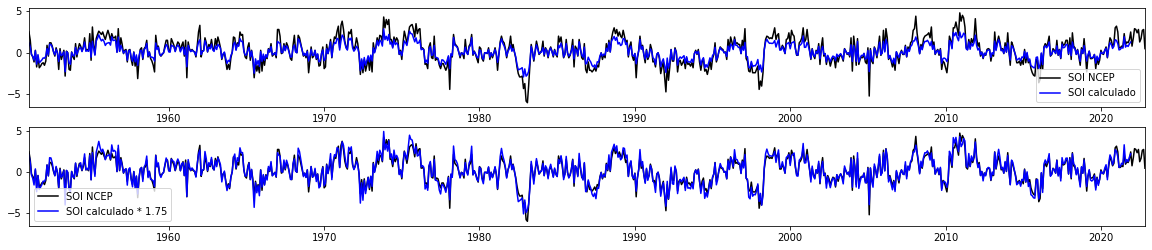

In [6]:
fig, (ax, ax2) = plt.subplots(2,1, figsize = (20,4))        # Comparativa SOI calculado vs SOI NCEP
ax.plot(SOI_NCEP, 'k-', label = 'SOI NCEP')
ax.plot(SOI['1950':'2021'], 'b-', label = 'SOI calculado')
ax.margins(x = 0)
ax.legend()

ax2.plot(SOI_NCEP, 'k-', label = 'SOI NCEP')
ax2.plot(SOI['1950':'2021'] * 1.75, 'b-', label = 'SOI calculado * 1.75')
ax2.margins(x = 0)
ax2.legend()

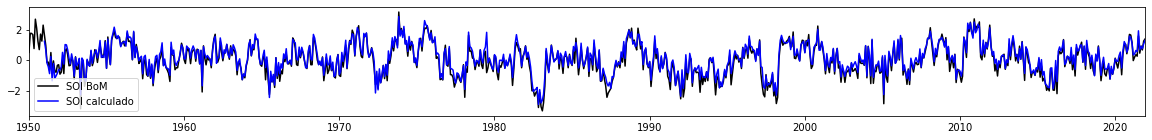

In [7]:
fig, ax = plt.subplots(figsize = (20,2))                        # Comparativa SOI calculado vs SOI BoM
ax.plot(SOI_BOM['1950':'2021'], 'k-', label = 'SOI BoM')
ax.plot(SOI['1950':'2021'], 'b-', label = 'SOI calculado')
# ax.plot(SOI['1950':'2021'].rolling(3, center = True).mean(), 'b-')
ax.margins(x = 0)
ax.legend()

<font color = 'blue'  size = 4>  Oceanic Niño Index (ONI)

In [8]:
ONI = pd.read_csv(path + 'oni_calc.csv', parse_dates = True, index_col = [0], dtype = {'oni':float}, decimal = ',')
# https://bmcnoldy.rsmas.miami.edu/tropics/oni/
ONI.head(3)

,Meses,oni
Fecha,,
1950-01-01,DJF,-1.469558
1950-02-01,JFM,-1.335814
1950-03-01,FMA,-1.164032


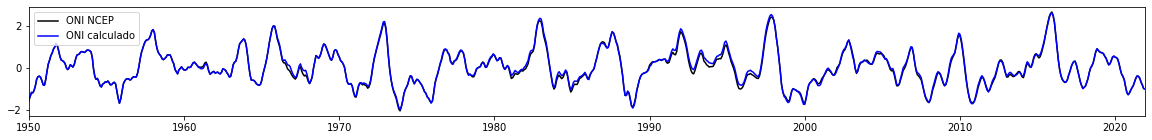

In [9]:
ONI_NCEP = pd.read_csv('https://psl.noaa.gov/data/correlation/oni.data', header = None, sep = '\s+', skiprows = 1, skipfooter = 8,
                        index_col = [0], na_values = [-99.9])
ONI_NCEP = ONI_NCEP.stack()
ONI_NCEP.index = pd.date_range('1950-01', periods = ONI_NCEP.shape[0], freq = 'MS')

fig, ax = plt.subplots(figsize = (20,2))
ax.plot(ONI_NCEP['1950':'2021'], 'k-', label = 'ONI NCEP')
ax.plot(ONI.loc['1950':'2021','oni'].round(2), 'b-', label = 'ONI calculado')
ax.margins(x = 0)
ax.legend()

<font color = 'blue' size = 4> Correlación con CHIRPS

1. Lectura del dataset CHIRPS 2.0

In [10]:
CHIRPS = xr.open_dataset(path_data + 'CHIRPS_PERU_1991-2021.nc', decode_times = False)
CHIRPS['T'] = pd.date_range('1991-01-01', '2022-10-01', freq = 'MS')
CHIRPS

<xarray.Dataset>
Dimensions:        (T: 382, Y: 450, X: 401)
Coordinates:
  * T              (T) datetime64[ns] 1991-01-01 1991-02-01 ... 2022-10-01
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
Data variables:
    precipitation  (T, Y, X) float32 ...

2. Climatología mensual 1991-2020

In [11]:
CHIRPS_clim = CHIRPS.sel(T = slice('1991','2020'))\
                        .groupby('T.month').mean('T')     # Climatología mensual
CHIRPS_clim

<xarray.Dataset>
Dimensions:        (Y: 450, X: 401, month: 12)
Coordinates:
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precipitation  (month, Y, X) float32 nan nan nan nan ... 89.46 85.92 86.13

2. Anomalía mensual

In [12]:
CHIRPS_anom = CHIRPS.groupby('T.month') - CHIRPS_clim     # Anomalías mensuales
CHIRPS_anom

<xarray.Dataset>
Dimensions:        (T: 382, Y: 450, X: 401)
Coordinates:
  * T              (T) datetime64[ns] 1991-01-01 1991-02-01 ... 2022-10-01
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
    month          (T) int64 1 2 3 4 5 6 7 8 9 10 11 ... 12 1 2 3 4 5 6 7 8 9 10
Data variables:
    precipitation  (T, Y, X) float32 nan nan nan nan ... -18.14 -18.07 -18.72

3. Anomalías estacionales

In [13]:
CHIRPS_anomS = CHIRPS_anom.resample(T = 'QS-Mar').mean()  # Anomalías estacionales
CHIRPS_anomS

<xarray.Dataset>
Dimensions:        (T: 128, Y: 450, X: 401)
Coordinates:
  * T              (T) datetime64[ns] 1990-12-01 1991-03-01 ... 2022-09-01
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
Data variables:
    precipitation  (T, Y, X) float32 nan nan nan nan ... -11.42 -11.4 -12.02

6. Cálculo del coeficiente de correlación de Spearman

In [14]:
def Spearman_corr(x,y):
    from scipy.stats import spearmanr
    r,p = spearmanr(x,y)
    return r
# https://www.martinjung.eu/post/2018_xarrayregression/
ref_period = ['1991','2020']    # Cambiar aquí
CHIRPS_corr = CHIRPS_anomS.sel(T = CHIRPS_anomS.T.dt.month == 12)\
                          .sel(T = slice(*ref_period))  # Seleccionar solo los DJF en el período de referencia.
Index_corr = ONI[ONI['Meses'] == 'DJF']\
                .loc[slice(*ref_period), 'oni'].values  # np.Array

CHIRPS_corr['Rho_ONI'] = xr.apply_ufunc(Spearman_corr,
                                        CHIRPS_corr.precipitation,
                                        Index_corr,
                                        input_core_dims = [['T'],['T']],
                                        vectorize = True)
CHIRPS_corr

<xarray.Dataset>
Dimensions:        (T: 30, Y: 450, X: 401)
Coordinates:
  * T              (T) datetime64[ns] 1991-12-01 1992-12-01 ... 2020-12-01
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
Data variables:
    precipitation  (T, Y, X) float32 nan nan nan nan ... -0.5917 0.0555 -1.283
    Rho_ONI        (Y, X) float64 nan nan nan nan ... -0.18 -0.1128 -0.1435

In [15]:
def Spearman_corr(x,y):
    from scipy.stats import spearmanr
    r,p = spearmanr(x,y, nan_policy = 'omit')
    return r

def Spearman_sig(x, y, alpha = 0.05):
    from scipy.stats import spearmanr
    r,p = spearmanr(x,y, nan_policy = 'omit')
    if p <= alpha:  sig = 1
    elif p > alpha: sig = 0
    else:           sig = np.nan
    return sig

ref_period = ['1991','2020']    # Cambiar aquí
CHIRPS_corr = CHIRPS_anomS.sel(T = CHIRPS_anomS.T.dt.month == 12)\
                          .sel(T = slice(*ref_period))  # Seleccionar solo los DJF en el período de referencia.
Index_corr = ONI[ONI['Meses'] == 'DJF']\
                .loc[slice(*ref_period), 'oni'].values  # np.Array

CHIRPS_corr['Rho_ONI_val'] = xr.apply_ufunc(Spearman_corr,
                                        CHIRPS_corr.precipitation,
                                        Index_corr,
                                        input_core_dims = [['T'],['T']],
                                        vectorize = True)

CHIRPS_corr['Rho_ONI_sig'] = xr.apply_ufunc(Spearman_sig,
                                        CHIRPS_corr.precipitation,
                                        Index_corr,
                                        input_core_dims = [['T'],['T']],
                                        vectorize = True)

CHIRPS_corr

# https://www.martinjung.eu/post/2018_xarrayregression/

<xarray.Dataset>
Dimensions:        (T: 30, Y: 450, X: 401)
Coordinates:
  * T              (T) datetime64[ns] 1991-12-01 1992-12-01 ... 2020-12-01
  * Y              (Y) float32 2.475 2.425 2.375 2.325 ... -19.88 -19.92 -19.97
  * X              (X) float32 -85.0 -84.95 -84.9 -84.85 ... -65.1 -65.05 -65.0
Data variables:
    precipitation  (T, Y, X) float32 nan nan nan nan ... -0.5917 0.0555 -1.283
    Rho_ONI_val    (Y, X) float64 nan nan nan nan ... -0.18 -0.1128 -0.1435
    Rho_ONI_sig    (Y, X) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0

In [16]:
# Lag correlation: ONI vs CHIRPS [1991-2020]

ref_period = ['1991','2020']    # Cambiar aquí
CHIRPS_ONI_corr = CHIRPS_anom.sel(T = slice(*ref_period))  # Seleccionar solo los DJF en el período de referencia.

for n in [0, -1, -3]:
    # Index_corr = SOI[slice(*ref_period)].shift(n).values  # lag, np.Array
    Index_corr = ONI.loc[slice(*ref_period),'oni'].shift(n).values

    CHIRPS_ONI_corr[f'Rho_ONI_lag[{n}]_val'] = xr.apply_ufunc(Spearman_corr,
                                            CHIRPS_ONI_corr.precipitation,
                                            Index_corr,
                                            input_core_dims = [['T'],['T']],
                                            vectorize = True)

    CHIRPS_ONI_corr[f'Rho_ONI_lag[{n}]_sig'] = xr.apply_ufunc(Spearman_sig,
                                            CHIRPS_ONI_corr.precipitation,
                                            Index_corr,
                                            input_core_dims = [['T'],['T']],
                                            vectorize = True)

CHIRPS_ONI_corr

<xarray.Dataset>
Dimensions:              (T: 360, Y: 450, X: 401)
Coordinates:
  * T                    (T) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01
  * Y                    (Y) float32 2.475 2.425 2.375 ... -19.88 -19.92 -19.97
  * X                    (X) float32 -85.0 -84.95 -84.9 ... -65.1 -65.05 -65.0
    month                (T) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
Data variables:
    precipitation        (T, Y, X) float32 nan nan nan ... -22.29 -18.62 -16.31
    Rho_ONI_lag[0]_val   (Y, X) float64 nan nan nan ... 0.04874 0.06813 0.06941
    Rho_ONI_lag[0]_sig   (Y, X) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    Rho_ONI_lag[-1]_val  (Y, X) float64 nan nan nan ... 0.05168 0.07028 0.06981
    Rho_ONI_lag[-1]_sig  (Y, X) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    Rho_ONI_lag[-3]_val  (Y, X) float64 nan nan nan ... 0.07474 0.09087 0.08415
    Rho_ONI_lag[-3]_sig  (Y, X) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0

### <font color = 'green'> Gráficos para el informe

In [17]:
import matplotlib.pyplot as plt, matplotlib.ticker as mticker,matplotlib.dates as mdates, cartopy.crs as ccrs
from cartopy.feature import BORDERS, OCEAN, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

projection = ccrs.PlateCarree()
mes = {1:'ENERO',2:'FEBRERO',3:'MARZO',4:'ABRIL',5:'MAYO',6:'JUNIO',
       7:'JULIO',8:'AGOSTO',9:'SETIEMBRE',10:'OCTUBRE',11:'NOVIEMBRE',12:'DICIEMBRE'}
season = {1:'Verano - DEF',2:'Invierno - JJA',3:'Otoño - MAM',4:'Primavera - SON'}

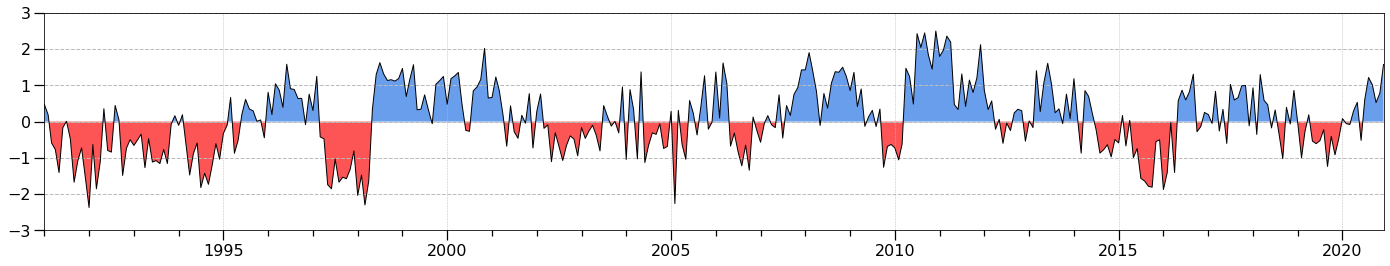

In [18]:
fig, ax = plt.subplots(1,1,figsize = (24,4))

x = SOI[slice(*ref_period)].index
y = SOI[slice(*ref_period)].values

ax.plot(x, y, 'k-', linewidth = 1)

ax.fill_between(x, 0, y, where= y >= 0, facecolor = '#699EEC', interpolate = True)
ax.fill_between(x, 0, y, where= y < 0, facecolor = '#FD5555', interpolate = True)

ax.set(ylim=(-3,3))
ax.margins(x = 0)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))

ax.yaxis.grid(ls = '--', lw = 1, color = '#BBBBBB', zorder = 1)
ax.xaxis.grid(ls = '--', lw = 0.5, color = '#BBBBBB', zorder = 1)
ax.hlines(0, *ax.get_xlim(), ls = '-', lw = 0.5, color = '#BBBBBB', zorder = 1)

ax.tick_params('both', length = 10, width = 1.25, labelsize = 16)
ax.tick_params('x', length = 6 , width = 1.25, which = 'minor')

fig.savefig(path + f'SOI.png', transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

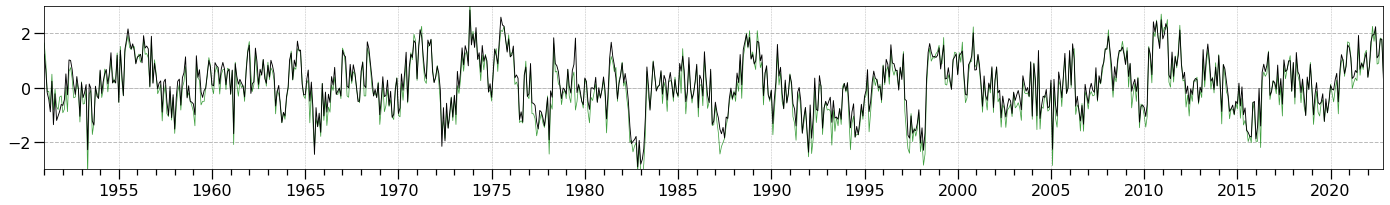

In [19]:
fig, ax = plt.subplots(1,1,figsize = (24,3))

x = SOI['1951':'2022'].index
y1 = SOI['1951':'2022'].values
y2 = SOI_BOM['1951':'2022'].values.flatten()

ax.plot(x, y2, 'g-', linewidth = 0.75, label = 'SOI BoM', alpha = 0.75)
ax.plot(x, y1, 'k-', linewidth = 0.9, label = 'SOI calculado')

ax.set(ylim=(-3,3))
ax.margins(x = 0)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))

ax.yaxis.grid(ls = '--', lw = 1, color = '#BBBBBB', zorder = 1)
ax.xaxis.grid(ls = '--', lw = 0.5, color = '#BBBBBB', zorder = 1)
ax.hlines(0, *ax.get_xlim(), ls = '-', lw = 0.5, color = '#BBBBBB', zorder = 1)

ax.tick_params('both', length = 10, width = 1.25, labelsize = 16)
ax.tick_params('x', length = 6 , width = 1.25, which = 'minor')

fig.savefig(path + f'SOI calc vs BoM.png', transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

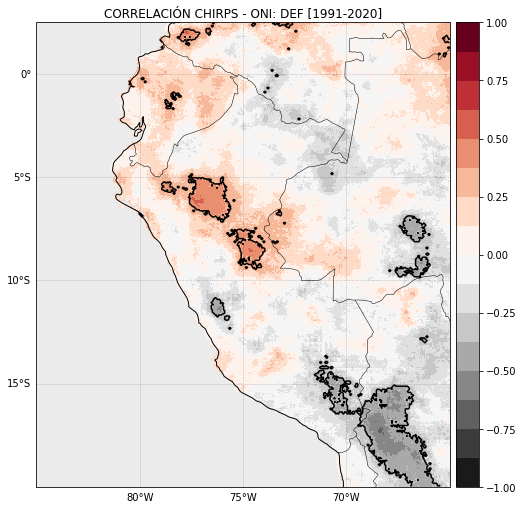

In [20]:
cmap = plt.get_cmap('RdGy_r', 16)
cmap.set_bad('#EBEBEB')

subplot_kws = dict(projection=ccrs.PlateCarree(), facecolor='white') 
fig, ax = plt.subplots(1,1, figsize = (10,10), subplot_kw = subplot_kws)

CHIRPS_corr['Rho_ONI_val'].plot(x='X', y='Y', ax = ax, transform = ccrs.PlateCarree(),
                         cmap = cmap, vmin = -1, vmax = 1,
                         cbar_kwargs={'orientation':'vertical', 'pad':0.01, 'label':''})

CHIRPS_corr['Rho_ONI_sig'].plot.contour(x='X', y='Y', ax=ax, transform = ccrs.PlateCarree(),
                                        colors = 'black', levels = [0], lw = 0.5)

ax.add_feature(BORDERS, color='black', lw = 0.5, zorder = 2)
ax.coastlines('50m')
ax.set_title('CORRELACIÓN CHIRPS - ONI: DEF [1991-2020]')

grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                            crs=ccrs.PlateCarree(),
                            draw_labels=True)

grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios

grids.xlocator = mticker.FixedLocator([x for x in range(-80,-70+5, 5)])  # labels x
grids.ylocator = mticker.FixedLocator([y for y in range(-20,  0+5, 5)])  # labels y
grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER
ax.margins(x = 0, y = 0)

plt.subplots_adjust(bottom = 0.255, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.15)

fig.savefig(path + f'CHIRPS_ONI_corr.png', transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

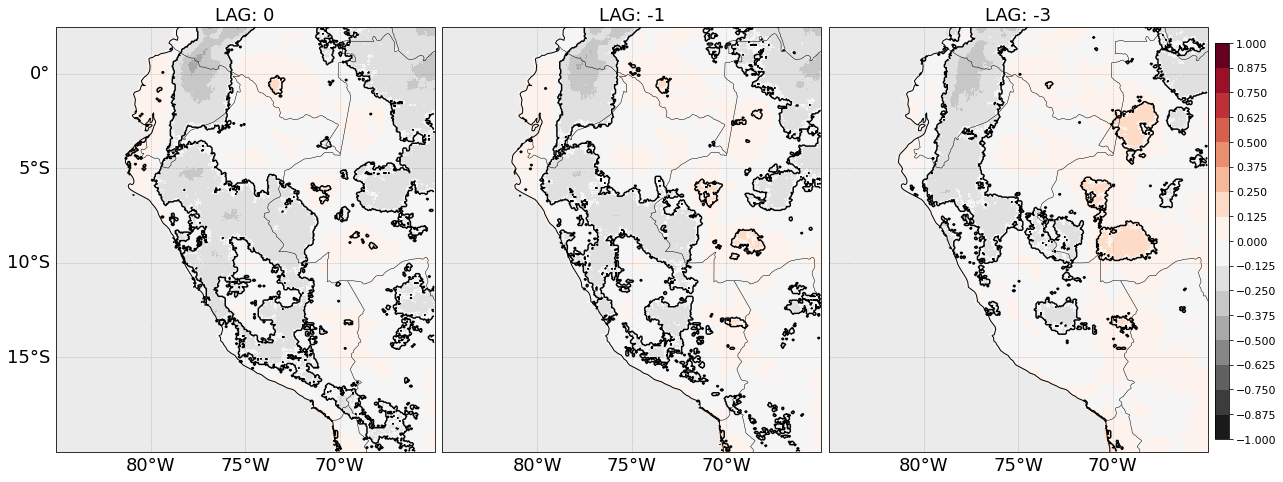

In [21]:
cmap = plt.get_cmap('RdGy_r', 16)
cmap.set_bad('#EBEBEB')

subplot_kws = dict(projection=ccrs.PlateCarree(), facecolor='white')
fig, Ax = plt.subplots(1,3, figsize = (20,10), subplot_kw = subplot_kws)

for n, ax in zip([0, -1, -3], Ax.flatten()):
    CHIRPS_ONI_corr[f'Rho_ONI_lag[{n}]_val'].plot(x='X', y='Y', ax = ax, transform = ccrs.PlateCarree(),
                            cmap = cmap, vmin = -1, vmax = 1, add_colorbar=False)

    CHIRPS_ONI_corr[f'Rho_ONI_lag[{n}]_sig'].plot.contour(x='X', y='Y', ax=ax, transform = ccrs.PlateCarree(),
                                            colors = 'black', levels = [0], lw = 0.5)

    ax.add_feature(BORDERS, color='black', lw = 0.5, zorder = 2)
    ax.coastlines('50m')
    ax.set_title(f'LAG: {n}', fontsize = 18)

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                              crs=ccrs.PlateCarree(), draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios

    if n in [-1, -3]:   grids.ylabels_left = False

    grids.xlocator = mticker.FixedLocator([x for x in range(-80,-70+5, 5)])  # labels x
    grids.ylocator = mticker.FixedLocator([y for y in range(-20,  0+5, 5)])  # labels y
    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER
    grids.xlabel_style = {'size': 18, 'color': 'k', 'rotation':0}
    grids.ylabel_style = {'size': 18, 'color': 'k', 'rotation':0}
    ax.margins(x = 0, y = 0)

cax = fig.add_axes([0.905,0.3,0.01,0.55])
bounds = [i for i in np.arange(-1, 1+0.00001, 0.125)]
import matplotlib as mpl
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = cax, ticks=bounds, norm=norm)
cb.ax.tick_params(labelsize=11)
cb.set_label('', rotation=270, fontsize=1, labelpad=0)

plt.subplots_adjust(bottom = 0.255, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.15)

fig.savefig(path + f'CHIRPS_ONI_corr.png',
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')